In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
import statsmodels.api as sm
from pandas import Timestamp
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression
from sklearn.metrics import mean_squared_error

# Collect historical data

In [2]:
tickerSymbol = '^GSPC'
start_date = '2000-01-01'
end_date = '2023-06-30'

tickerData = yf.Ticker(tickerSymbol)
data = tickerData.history(period='1d', start=start_date, end=end_date).dropna()
data.index = data.index.normalize()
data.index = data.index.tz_localize(None)
data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,931800000,0.0,0.0
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1009000000,0.0,0.0
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1085500000,0.0,0.0
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1092300000,0.0,0.0
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1225200000,0.0,0.0
...,...,...,...,...,...,...,...
2023-06-23,4354.169922,4366.549805,4341.339844,4348.330078,6053620000,0.0,0.0
2023-06-26,4344.839844,4362.060059,4328.080078,4328.819824,3415030000,0.0,0.0
2023-06-27,4337.359863,4384.419922,4335.000000,4378.410156,3573500000,0.0,0.0


# Identify relevant indicators

## Economic indicators

In [3]:
fred = Fred(api_key='93d1c8c5ed4f150818b57df3952760fe')

gdp_data = fred.get_series('GDP', observation_start=start_date, observation_end=end_date)
gdp_filled_data = gdp_data.resample('D').ffill().dropna()
gdp_filled_data = gdp_filled_data.to_frame(name='GDP')
gdp_filled_data.reset_index(inplace=True)
gdp_filled_data.rename(columns={'index': 'Date'}, inplace=True)
gdp_filled_data = gdp_filled_data.set_index('Date')
gdp_filled_data

,GDP
Date,
2000-01-01,10002.179
2000-01-02,10002.179
2000-01-03,10002.179
2000-01-04,10002.179
2000-01-05,10002.179
...,...
2023-03-28,26813.601
2023-03-29,26813.601
2023-03-30,26813.601


In [4]:
unemployment_data = fred.get_series('UNRATE', observation_start=start_date, observation_end=end_date)
unemployment_filled_data = unemployment_data.resample('D').ffill().dropna()
unemployment_filled_data = unemployment_filled_data.to_frame(name='Unemployment_Rate')
unemployment_filled_data.reset_index(inplace=True)
unemployment_filled_data.rename(columns={'index': 'Date'}, inplace=True)
unemployment_filled_data = unemployment_filled_data.set_index('Date')
unemployment_filled_data

,Unemployment_Rate
Date,
2000-01-01,4.0
2000-01-02,4.0
2000-01-03,4.0
2000-01-04,4.0
2000-01-05,4.0
...,...
2023-05-28,3.7
2023-05-29,3.7
2023-05-30,3.7


In [5]:
cpi_data = fred.get_series('CPIAUCSL', observation_start=start_date, observation_end=end_date)
cpi_filled_data = cpi_data.resample('D').ffill().dropna()
cpi_filled_data = cpi_filled_data.to_frame(name='CPI')
cpi_filled_data.reset_index(inplace=True)
cpi_filled_data.rename(columns={'index': 'Date'}, inplace=True)
cpi_filled_data = cpi_filled_data.set_index('Date')
cpi_filled_data

,CPI
Date,
2000-01-01,169.300
2000-01-02,169.300
2000-01-03,169.300
2000-01-04,169.300
2000-01-05,169.300
...,...
2023-05-28,303.294
2023-05-29,303.294
2023-05-30,303.294


In [6]:
interest_rate_data = fred.get_series('FEDFUNDS', observation_start=start_date, observation_end=end_date)
interest_filled_rate_data = interest_rate_data.resample('D').ffill().dropna() 
interest_filled_rate_data = interest_filled_rate_data.to_frame(name='Interest_Rate')
interest_filled_rate_data.reset_index(inplace=True)
interest_filled_rate_data.rename(columns={'index': 'Date'}, inplace=True)
interest_filled_rate_data = interest_filled_rate_data.set_index('Date')
interest_filled_rate_data

,Interest_Rate
Date,
2000-01-01,5.45
2000-01-02,5.45
2000-01-03,5.45
2000-01-04,5.45
2000-01-05,5.45
...,...
2023-05-28,5.06
2023-05-29,5.06
2023-05-30,5.06


## Market indicators

In [7]:
vix_data = yf.download('^VIX', start=start_date, end=end_date).dropna()
vix_data = vix_data['Adj Close'].rename('VIX')
vix_data

[*********************100%%**********************]  1 of 1 completed


Date
2000-01-03    24.209999
2000-01-04    27.010000
2000-01-05    26.410000
2000-01-06    25.730000
2000-01-07    21.719999
                ...    
2023-06-23    13.440000
2023-06-26    14.250000
2023-06-27    13.740000
2023-06-28    13.430000
2023-06-29    13.540000
Name: VIX, Length: 5910, dtype: float64

In [8]:
treasury_yield_data = yf.download('^TNX', start=start_date, end=end_date).dropna()
treasury_yield_data = treasury_yield_data['Adj Close'].rename('Treasury_Yield')
treasury_yield_data

[*********************100%%**********************]  1 of 1 completed


Date
2000-01-03    6.548
2000-01-04    6.485
2000-01-05    6.599
2000-01-06    6.549
2000-01-07    6.504
              ...  
2023-06-23    3.739
2023-06-26    3.719
2023-06-27    3.768
2023-06-28    3.710
2023-06-29    3.854
Name: Treasury_Yield, Length: 5903, dtype: float64

# Data Preparation and Preprocessing

## Data Aggregation

In [9]:
def merge(combined_df, df):
    return combined_df.merge(df, left_index=True, right_index=True, how='left')

dfs = [gdp_filled_data, unemployment_filled_data, cpi_filled_data, 
                           interest_filled_rate_data, vix_data, treasury_yield_data]

for df in dfs:
    data = merge(data, df)

data = data.drop(columns=['Open', 'High', 'Low', 'Dividends', 'Stock Splits'])
data['Return'] = data['Close'].pct_change()
data = data.dropna()
data

,Close,Volume,GDP,Unemployment_Rate,CPI,Interest_Rate,VIX,Treasury_Yield,Return
Date,,,,,,,,,
2000-01-04,1399.420044,1009000000,10002.179,4.0,169.300,5.45,27.010000,6.485,-0.038345
2000-01-05,1402.109985,1085500000,10002.179,4.0,169.300,5.45,26.410000,6.599,0.001922
2000-01-06,1403.449951,1092300000,10002.179,4.0,169.300,5.45,25.730000,6.549,0.000956
2000-01-07,1441.469971,1225200000,10002.179,4.0,169.300,5.45,21.719999,6.504,0.027090
2000-01-10,1457.599976,1064800000,10002.179,4.0,169.300,5.45,21.709999,6.558,0.011190
...,...,...,...,...,...,...,...,...,...
2023-03-27,3977.530029,4233540000,26813.601,3.5,301.808,4.65,20.600000,3.528,0.001647
2023-03-28,3971.270020,4014600000,26813.601,3.5,301.808,4.65,19.969999,3.564,-0.001574
2023-03-29,4027.810059,4145250000,26813.601,3.5,301.808,4.65,19.120001,3.566,0.014237


# Exploratory Data Analysis (EDA)

## Plotting the closing prices of the S&P 500

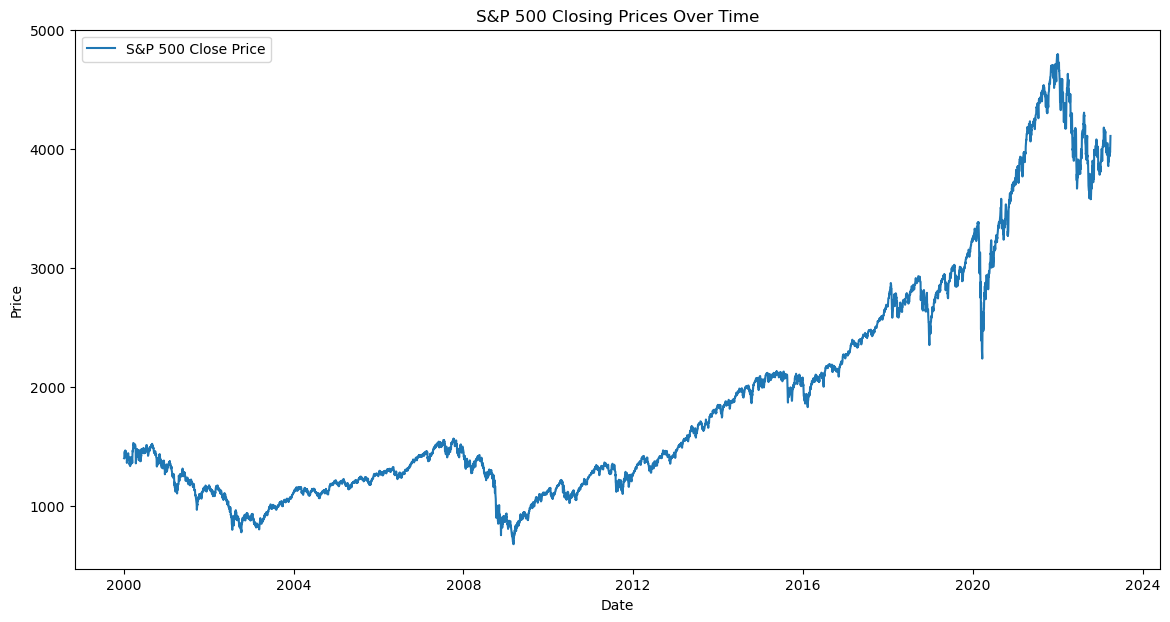

In [10]:
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='S&P 500 Close Price')
plt.title('S&P 500 Closing Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

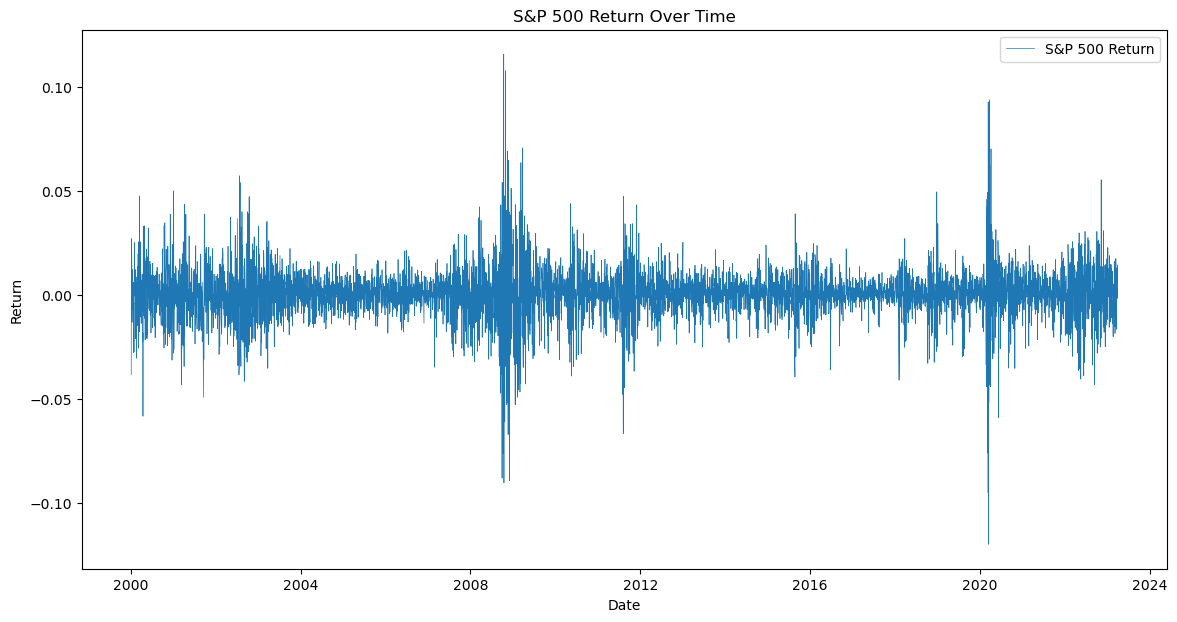

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(data['Return'], label='S&P 500 Return', linewidth = '0.5')
plt.title('S&P 500 Return Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.show()

## Plotting the GDP over time

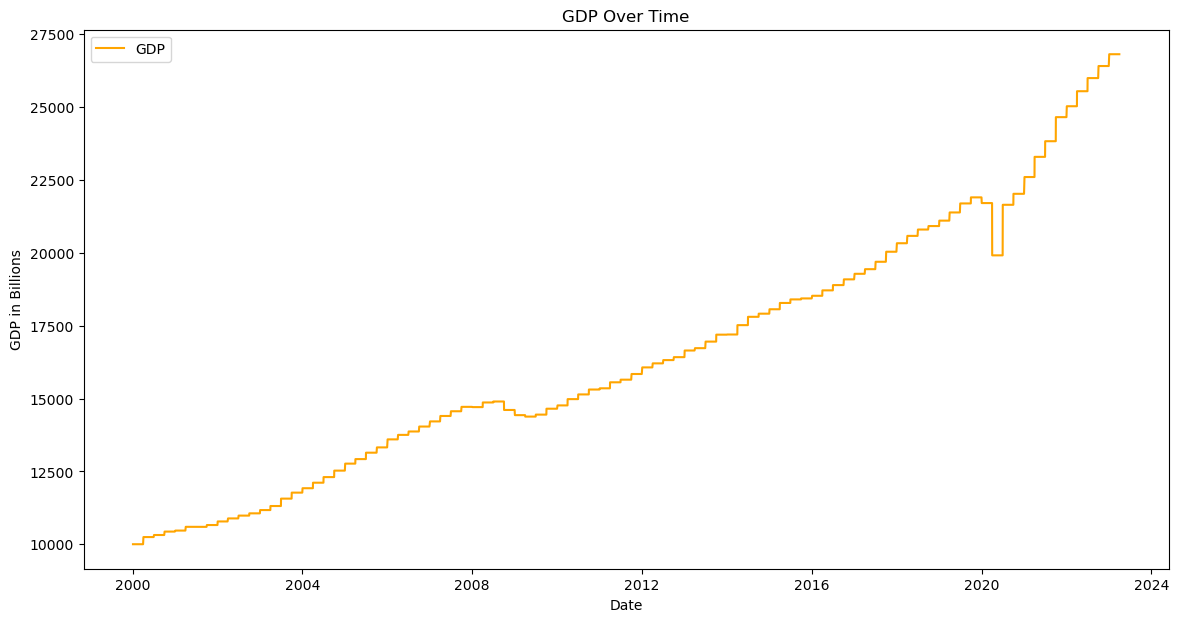

In [12]:
plt.figure(figsize=(14, 7))
plt.plot(data['GDP'], color='orange', label='GDP')
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP in Billions')
plt.legend()
plt.show()

## Plotting the unemployment rate over time

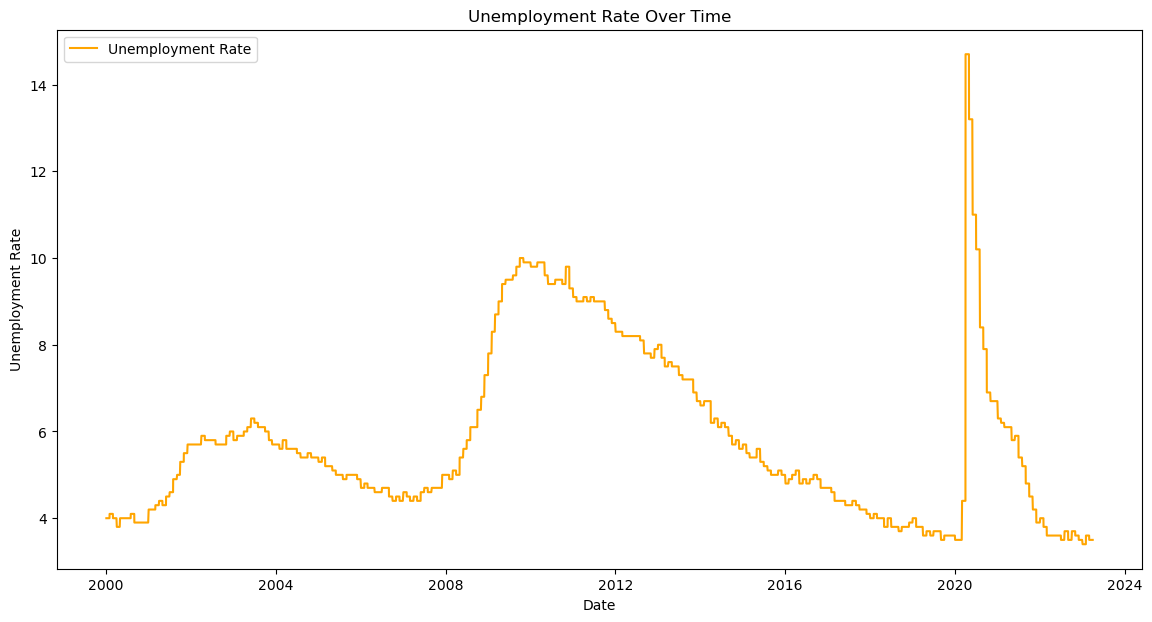

In [13]:
plt.figure(figsize=(14, 7))
plt.plot(data['Unemployment_Rate'], color='orange', label='Unemployment Rate')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()

## Plotting the CPI over time

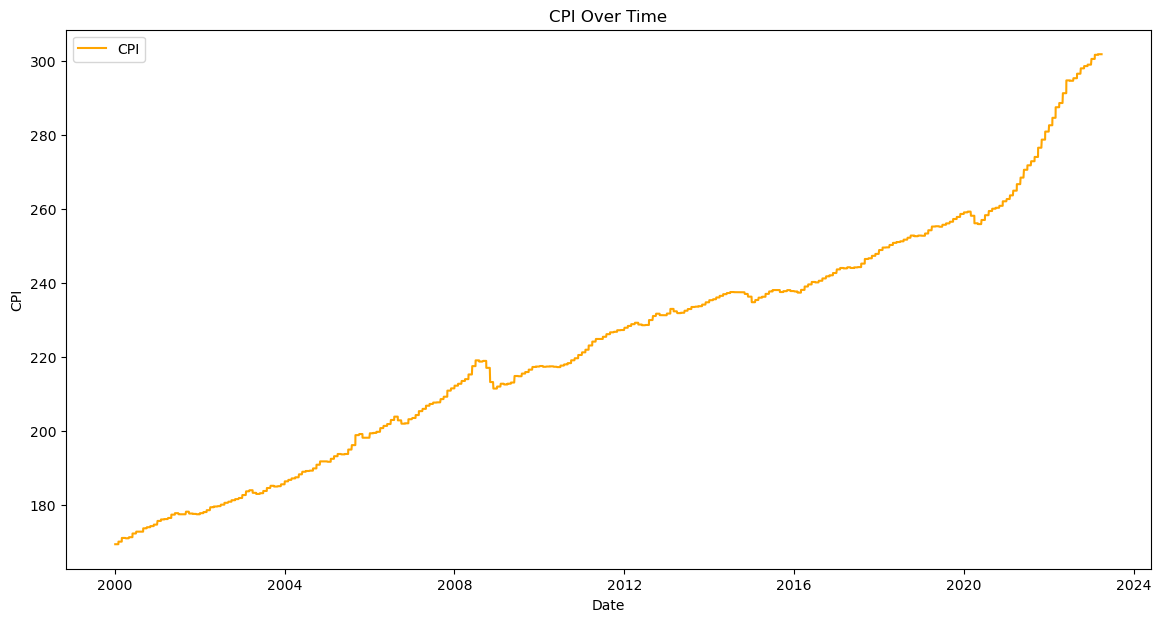

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(data['CPI'], color='orange', label='CPI')
plt.title('CPI Over Time')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.show()

## Plotting the interest rate over time

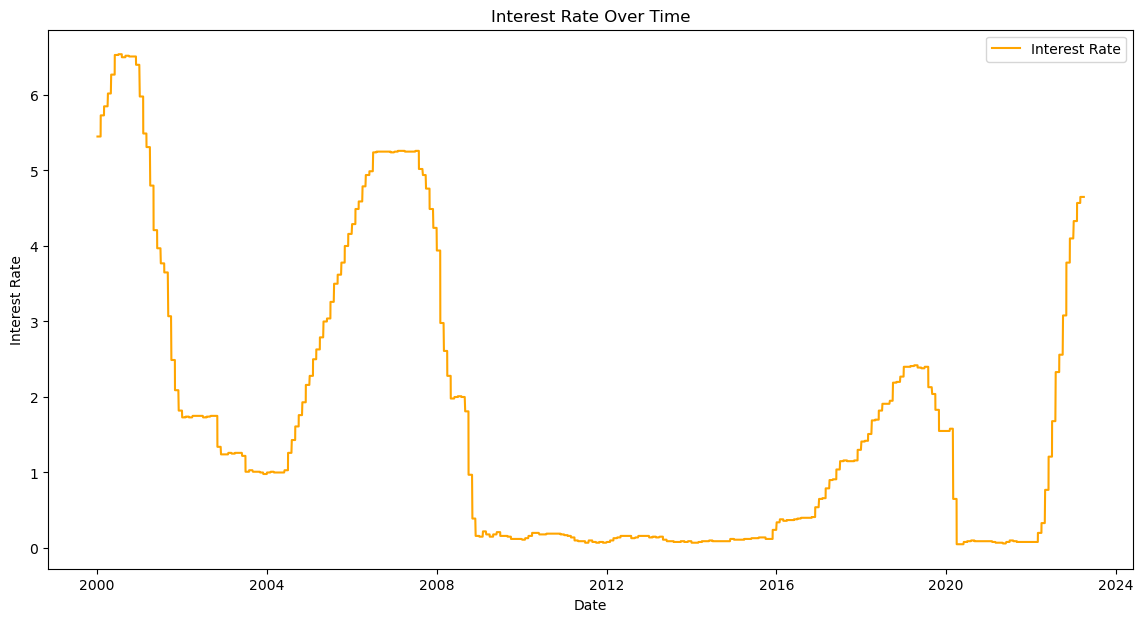

In [15]:
plt.figure(figsize=(14, 7))
plt.plot(data['Interest_Rate'], color='orange', label='Interest Rate')
plt.title('Interest Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Interest Rate')
plt.legend()
plt.show()

## Plotting the treasury yield over time

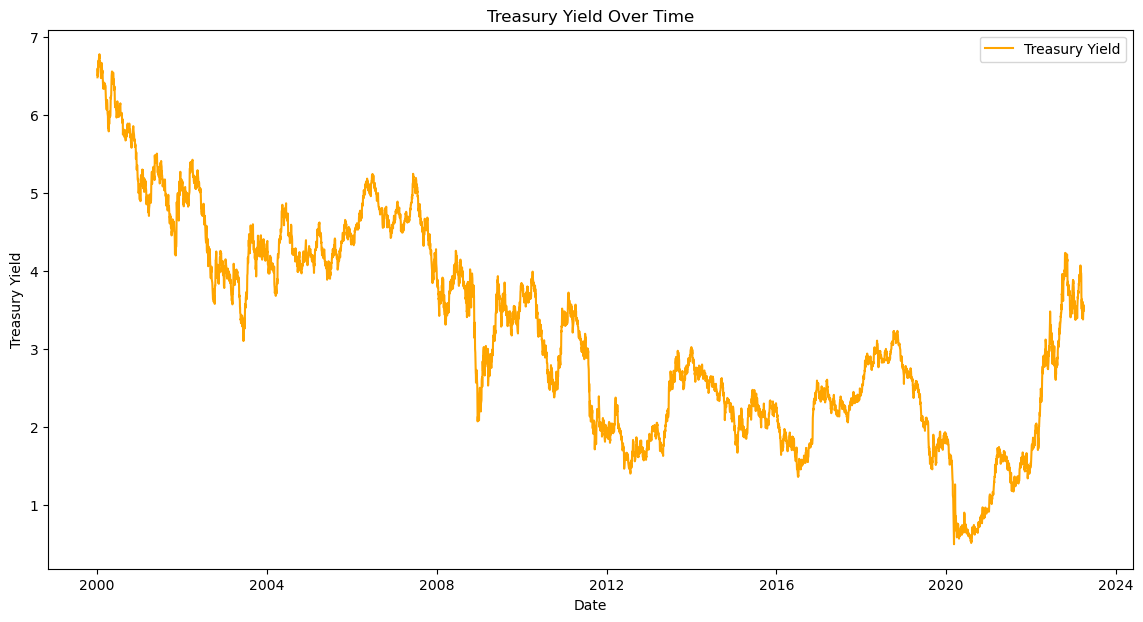

In [16]:
plt.figure(figsize=(14, 7))
plt.plot(data['Treasury_Yield'], color='orange', label='Treasury Yield')
plt.title('Treasury Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Treasury Yield')
plt.legend()
plt.show()

## Plotting the correlation matrix

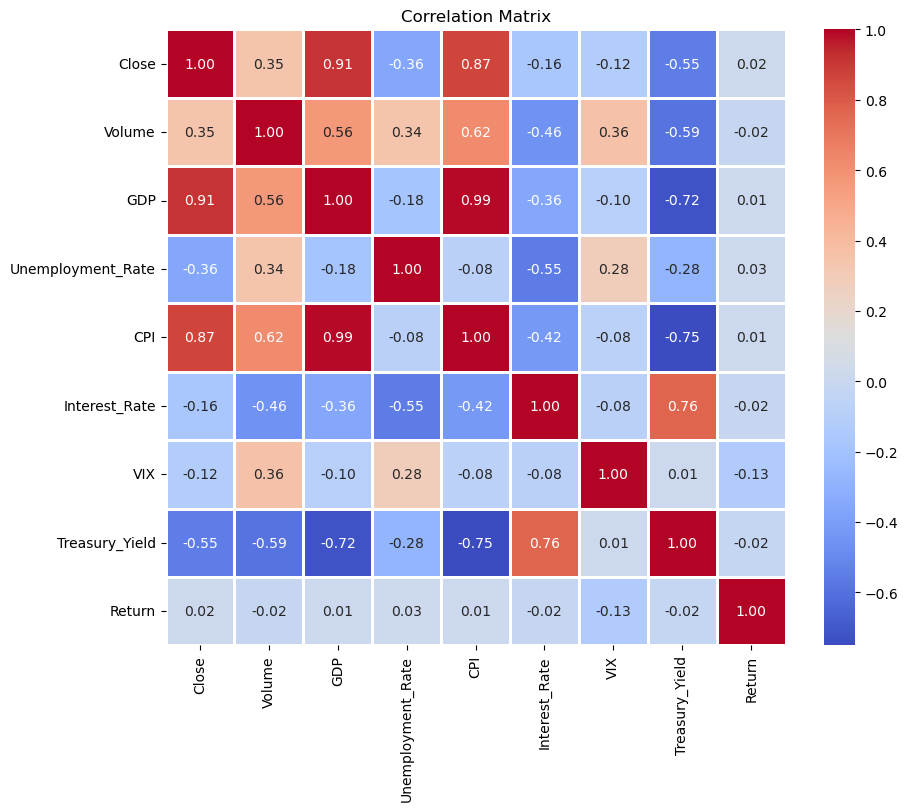

,Close,Volume,GDP,Unemployment_Rate,CPI,Interest_Rate,VIX,Treasury_Yield,Return
Close,1.000000,0.348146,0.914326,-0.355649,0.866411,-0.164473,-0.118814,-0.546493,0.019358
Volume,0.348146,1.000000,0.564727,0.344412,0.621539,-0.462267,0.358813,-0.586806,-0.018752
GDP,0.914326,0.564727,1.000000,-0.184858,0.990489,-0.360828,-0.101005,-0.719216,0.012710
Unemployment_Rate,-0.355649,0.344412,-0.184858,1.000000,-0.082792,-0.553954,0.277430,-0.279668,0.028304
CPI,0.866411,0.621539,0.990489,-0.082792,1.000000,-0.423193,-0.076842,-0.750671,0.013010
Interest_Rate,-0.164473,-0.462267,-0.360828,-0.553954,-0.423193,1.000000,-0.083784,0.763440,-0.017215
VIX,-0.118814,0.358813,-0.101005,0.277430,-0.076842,-0.083784,1.000000,0.010752,-0.131137
Treasury_Yield,-0.546493,-0.586806,-0.719216,-0.279668,-0.750671,0.763440,0.010752,1.000000,-0.020222
Return,0.019358,-0.018752,0.012710,0.028304,0.013010,-0.017215,-0.131137,-0.020222,1.000000


In [17]:
correlation_matrix = data[['Close', 'Volume', 'GDP', 'Unemployment_Rate', 'CPI', 'Interest_Rate', 'VIX', 'Treasury_Yield', 'Return']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=2)
plt.title('Correlation Matrix')
plt.show()

correlation_matrix

## Print the descriptive statistics

In [18]:
descriptive_stats = data.describe()
descriptive_stats

,Close,Volume,GDP,Unemployment_Rate,CPI,Interest_Rate,VIX,Treasury_Yield,Return
count,5841.000000,5.841000e+03,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,1896.909043,3.310977e+09,16507.910024,5.835251,223.922230,1.672952,20.199512,3.206380,0.000256
std,985.258891,1.524911e+09,4311.051251,1.961726,32.185954,1.877165,8.657760,1.324586,0.012495
min,676.530029,3.560700e+08,10002.179000,3.400000,169.300000,0.050000,9.140000,0.499000,-0.119841
25%,1185.619995,1.997100e+09,13324.204000,4.400000,198.100000,0.130000,13.980000,2.137000,-0.004894
50%,1438.099976,3.418730e+09,15647.680000,5.400000,226.106000,1.010000,18.299999,3.000000,0.000582
75%,2419.379883,4.166000e+09,19438.643000,6.700000,244.193000,2.400000,23.910000,4.231000,0.005971
max,4796.560059,1.145623e+10,26813.601000,14.700000,301.808000,6.540000,82.690002,6.781000,0.115800


# Implementing the Markov Regime Switching Model

## Training the model

In [19]:
markov_model = MarkovRegression(data['Return'].iloc[0:], k_regimes=2, trend='c', switching_variance=True)
markov_results = markov_model.fit()
markov_results.summary()

/Users/marklee/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 Return   No. Observations:                 5841
Model:               MarkovRegression   Log Likelihood               18512.895
Date:                Fri, 22 Dec 2023   AIC                         -37013.791
Time:                        16:24:52   BIC                         -36973.755
Sample:                             0   HQIC                        -36999.869
                               - 5841                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      6.671      0.000       0.001       0.001
sigma2      4.859e-05   1.76e-06     27.599      0.000    4.51e-05     5.2e-05
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0008      0.000     -1.808      0.071      -0.002    6.78e-05
sigma2         0.0004   1.53e-05     24.343      0.000       0.000       0.000
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.9878      0.002    410.903      0.000       0.983       0.993
p[1->0]        0.0244      0.005      5.070      0.000       0.015       0.034
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [20]:
markov_results.smoothed_marginal_probabilities.tail()

,0,1
Date,,
2023-03-27,0.732566,0.267434
2023-03-28,0.740556,0.259444
2023-03-29,0.733246,0.266754
2023-03-30,0.734667,0.265333
2023-03-31,0.722338,0.277662


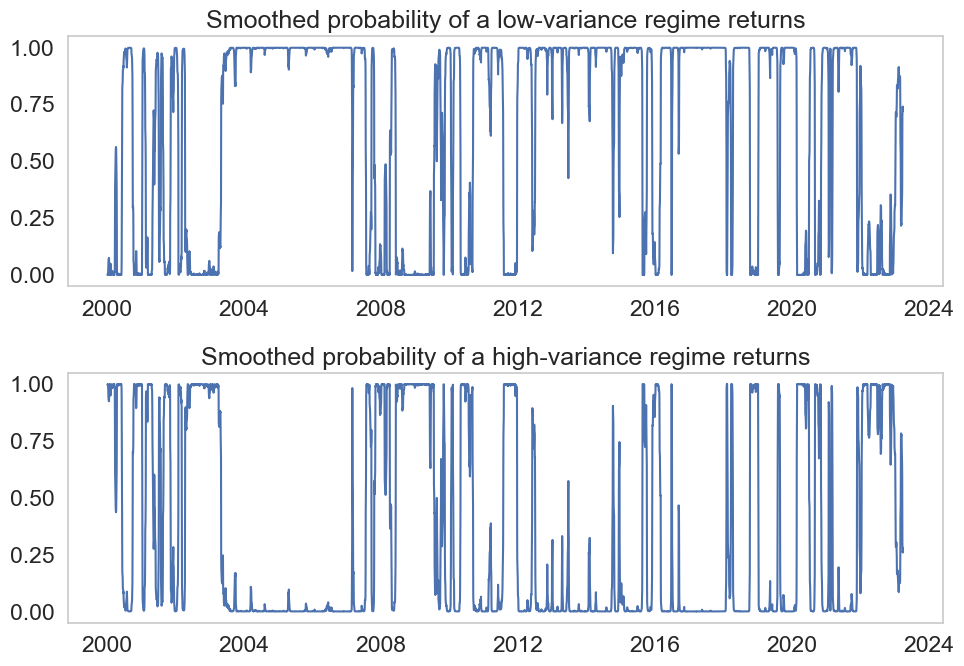

In [41]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(markov_results.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(markov_results.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

In [22]:
low_var = list(markov_results.smoothed_marginal_probabilities[0])
high_var = list(markov_results.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [23]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

Text(0.5, 0.98, 'Historical SP500 regimes')

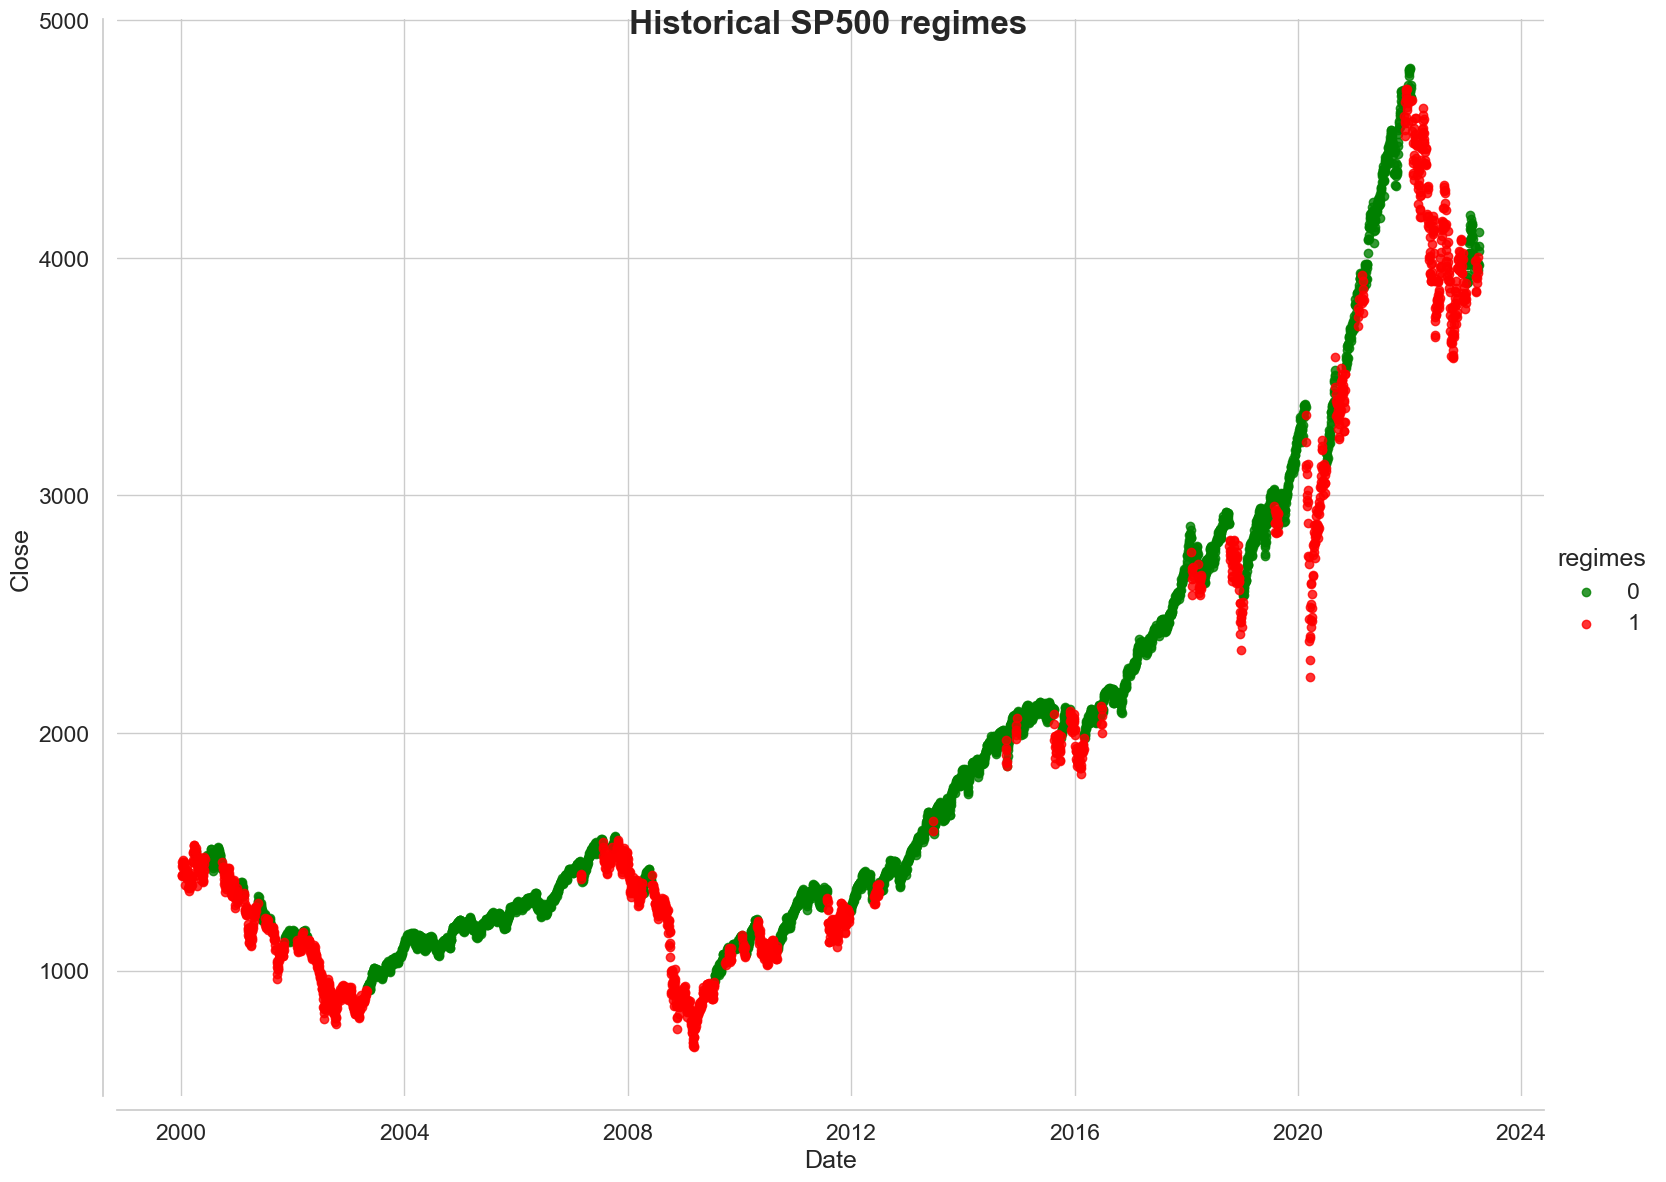

In [24]:
sns.set(font_scale=1.5)
df = data.iloc[len(data)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SP500 regimes', fontsize=24, fontweight='demi')

# Extending the Model with Exogenous Variables

In [25]:
exog_vars = data[['Unemployment_Rate', 'Interest_Rate', 'Treasury_Yield']] #'GDP', 'Unemployment_Rate', 'CPI', 'Interest_Rate', 'VIX', 'Treasury_Yield', 'Return'

extended_markov_model = MarkovRegression(
    data['Return'].iloc[0:], 
    exog=exog_vars.iloc[0:], 
    k_regimes=2, 
    trend='c', 
    switching_variance=True
)
extended_markov_results = extended_markov_model.fit()
print(extended_markov_results.summary())

                        Markov Switching Model Results                        
Dep. Variable:                 Return   No. Observations:                 5841
Model:               MarkovRegression   Log Likelihood               18519.806
Date:                Fri, 22 Dec 2023   AIC                         -37015.611
Time:                        16:24:56   BIC                         -36935.540
Sample:                             0   HQIC                        -36987.767
                               - 5841                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      1.027      0.305      -0.001       0.002
x1             0.0002   8.94e-05      2.129      0.0

In [26]:
extended_markov_results.smoothed_marginal_probabilities.tail()

,0,1
Date,,
2023-03-27,0.748289,0.251711
2023-03-28,0.756445,0.243555
2023-03-29,0.748799,0.251201
2023-03-30,0.750072,0.249928
2023-03-31,0.736915,0.263085


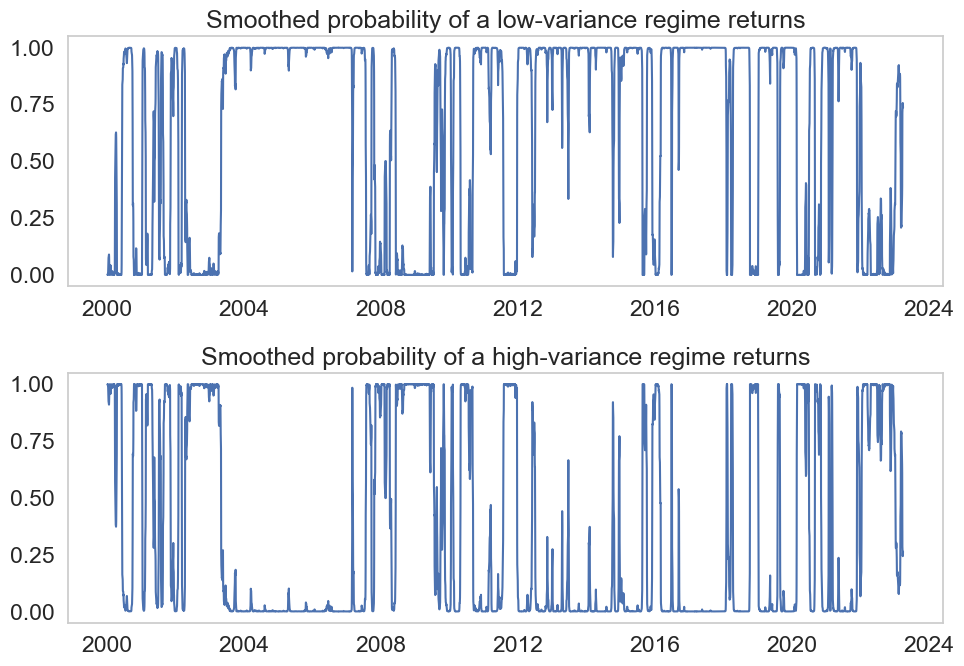

In [40]:
fig, axes = plt.subplots(2, figsize=(10,7))
ax = axes[0]
ax.plot(extended_markov_results.smoothed_marginal_probabilities[0])
ax.grid(False)
ax.set(title='Smoothed probability of a low-variance regime returns')
ax = axes[1]
ax.plot(extended_markov_results.smoothed_marginal_probabilities[1])
ax.set(title='Smoothed probability of a high-variance regime returns')
fig.tight_layout()
ax.grid(False)

In [28]:
low_var = list(extended_markov_results.smoothed_marginal_probabilities[0])
high_var = list(extended_markov_results.smoothed_marginal_probabilities[1])

regime_list = []
for i in range(0, len(low_var)):
    if low_var[i] > high_var[i]:
        regime_list.append(0)
    else:
        regime_list.append(1)

In [29]:
regime_df = pd.DataFrame()
regime_df['regimes'] = regime_list

Text(0.5, 0.98, 'Historical SP500 regimes')

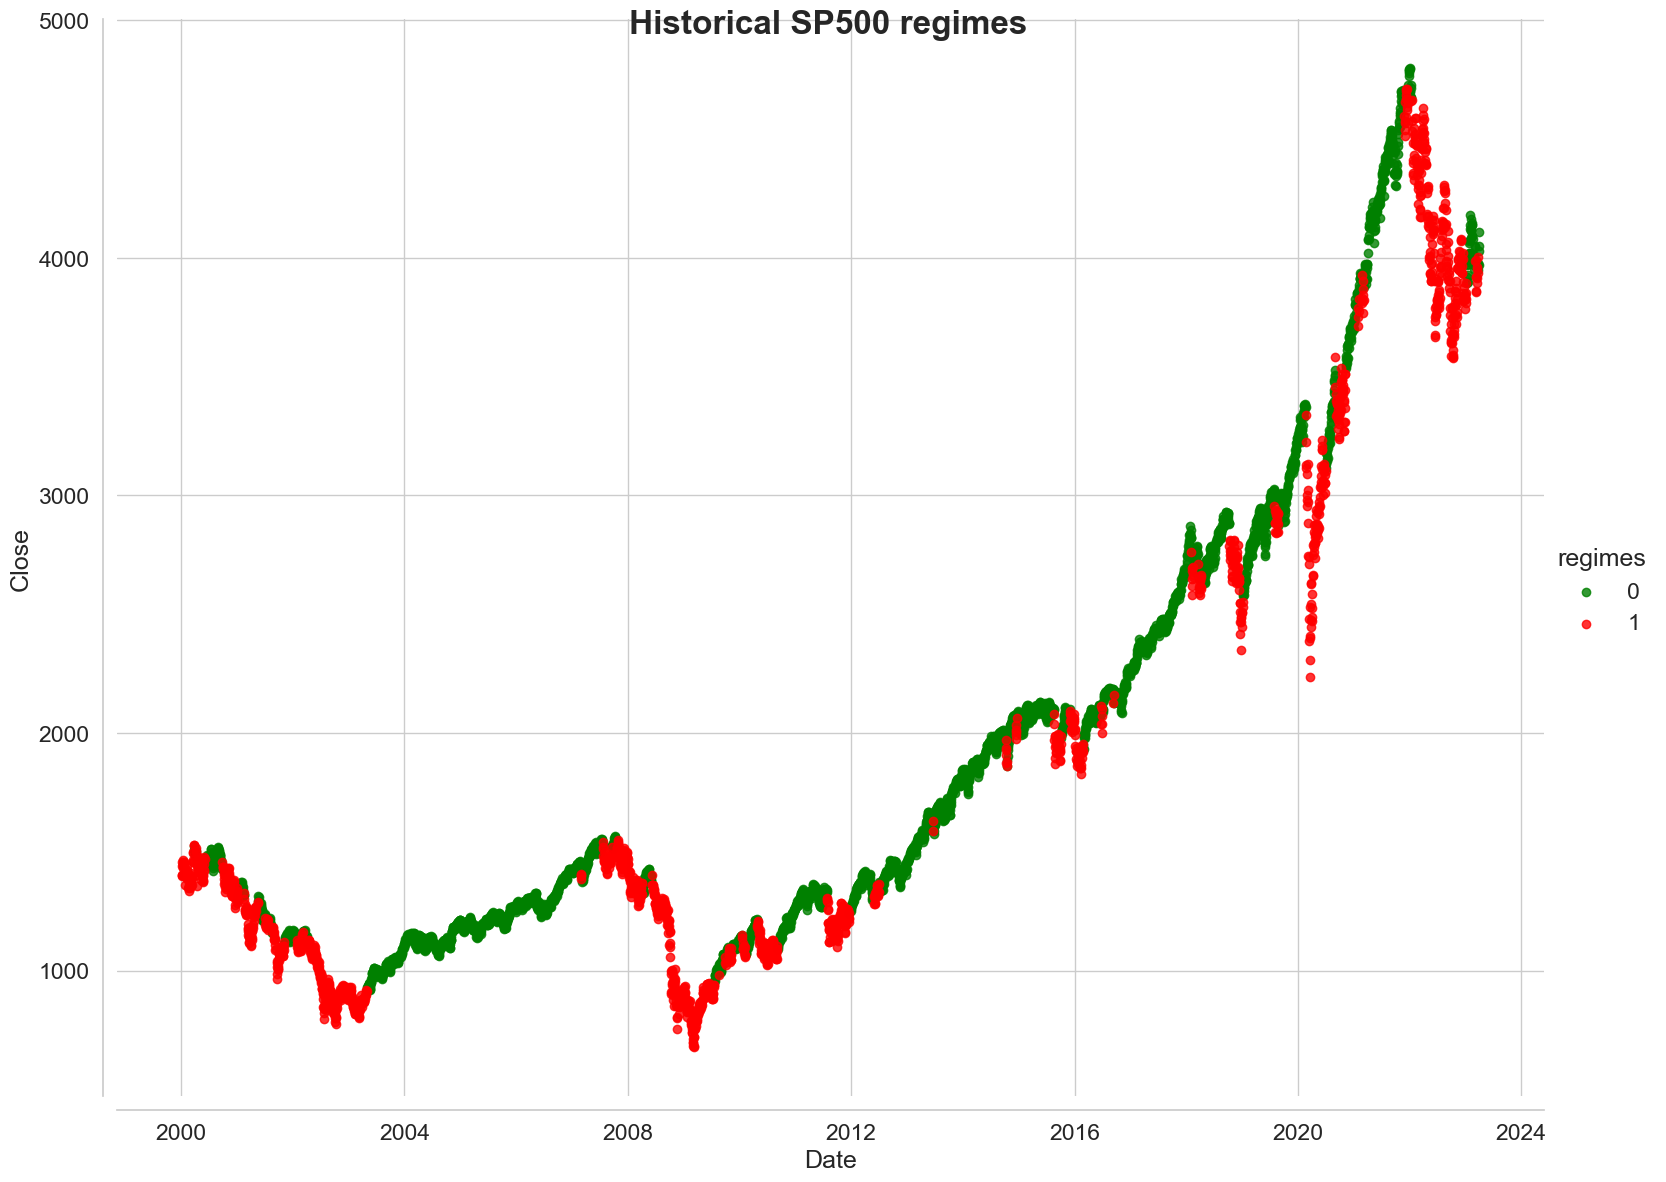

In [30]:
sns.set(font_scale=1.5)
df = data.iloc[len(data)-len(regime_list):]
regimes = (pd.DataFrame(regime_list, columns=['regimes'], index=df.index)
          .join(df, how='inner')
          .reset_index(drop=False)
          .rename(columns={'index':'Date'}))
regimes.head()

import warnings
warnings.filterwarnings("ignore")
colors = 'green', 'red', 'yellow'
sns.set_style("whitegrid")
order = [0, 1]
fg = sns.FacetGrid(data=regimes, hue='regimes', hue_order=order,
                   palette=colors, aspect=1.31, height=12)
fg.map(plt.scatter, 'Date', "Close", alpha=0.8).add_legend()
sns.despine(offset=10)
fg.fig.suptitle('Historical SP500 regimes', fontsize=24, fontweight='demi')

In [31]:
log_likelihood_without_exog = markov_results.llf
log_likelihood_with_exog = extended_markov_results.llf

aic_without_exog = markov_results.aic
aic_with_exog = extended_markov_results.aic

bic_without_exog = markov_results.bic
bic_with_exog = extended_markov_results.bic

# Print comparison results
print("Log-Likelihood without exogenous variables: ", round(log_likelihood_without_exog, 7))
print("Log-Likelihood with exogenous variables: ", round(log_likelihood_with_exog, 7))
print("Difference in Log-Likelihood: ", round(log_likelihood_with_exog - log_likelihood_without_exog, 7))

print("AIC without exogenous variables: ", round(aic_without_exog, 7))
print("AIC with exogenous variables: ", round(aic_with_exog, 7))
print("Difference in AIC: ", round(aic_with_exog - aic_without_exog, 7))

print("BIC without exogenous variables: ", round(bic_without_exog, 7))
print("BIC with exogenous variables: ", round(bic_with_exog, 7))
print("Difference in BIC: ", round(bic_with_exog - bic_without_exog, 7))

Log-Likelihood without exogenous variables:  18512.8953853
Log-Likelihood with exogenous variables:  18519.8057497
Difference in Log-Likelihood:  6.9103644
AIC without exogenous variables:  -37013.7907707
AIC with exogenous variables:  -37015.6114994
Difference in AIC:  -1.8207288
BIC without exogenous variables:  -36973.7548269
BIC with exogenous variables:  -36935.5396119
Difference in BIC:  38.215215


According to Log-Likelihood and AIC, the model with exogenous variables has better performance.

Why not add other exogenous variables to fit the model? First, a convergence issue happens when we put all our exogenous variables. The optimization algorithm cannot converge to a solution. Suppose the model has too many parameters relative to the amount of data. In that case, it can also lead to overfitting, and the optimization algorithm might not be able to estimate the parameters reliably. Second, GDP is quarterly data, and CPI is monthly data. These two data are insufficient for the model which used S&P 500 daily return as the main data.

# Testing the Model

In [32]:
markov_predictions = markov_results.predict()
extended_markov_predictions = extended_markov_results.predict()

In [33]:
markov_mse = mean_squared_error(data['Return'], markov_predictions)
extended_markov_mse = mean_squared_error(data['Return'], extended_markov_predictions)

In [34]:
print("MSE of the model without exogenous variables: ", round(markov_mse, 7))
print("MSE of the model with exogenous variables: ", round(extended_markov_mse, 7))

MSE of the model without exogenous variables:  0.0001554
MSE of the model with exogenous variables:  0.0001551


# Refining the Model

In [35]:
refined_markov_model = MarkovRegression(
    data['Return'].iloc[0:], 
    exog=exog_vars.iloc[0:], 
    k_regimes=4, 
    trend='n', 
    switching_variance=True
)
refined_markov_results = refined_markov_model.fit()
print(refined_markov_results.summary())

                        Markov Switching Model Results                        
Dep. Variable:                 Return   No. Observations:                 5841
Model:               MarkovRegression   Log Likelihood               18818.206
Date:                Fri, 22 Dec 2023   AIC                         -37580.411
Time:                        16:25:42   BIC                         -37393.577
Sample:                             0   HQIC                        -37515.442
                               - 5841                                         
Covariance Type:               approx                                         
                                 Regime 0 parameters                                 
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Unemployment_Rate     0.0003   5.67e-05      4.449      0.000       0.000       0.000
Interest_Rate         0.

In [36]:
refined_markov_predictions = refined_markov_results.predict()

In [37]:
refined_markov_mse = mean_squared_error(data['Return'], refined_markov_predictions)

In [38]:
print("MSE of the refined model with exogenous variables: ", round(refined_markov_mse, 7))

MSE of the refined model with exogenous variables:  0.000151


In [39]:
refined_log_likelihood_with_exog = refined_markov_results.llf
refined_aic_with_exog = refined_markov_results.aic
refined_bic_with_exog = refined_markov_results.bic

print("Log-Likelihood with exogenous variables: ", round(log_likelihood_with_exog, 7))
print("Log-Likelihood of the refined model with exogenous variables: ", round(refined_log_likelihood_with_exog, 7))
print("Difference in Log-Likelihood: ", round(refined_log_likelihood_with_exog - log_likelihood_with_exog, 7))

print("AIC with exogenous variables: ", round(aic_with_exog, 7))
print("AIC of the refined model with exogenous variables: ", round(refined_aic_with_exog, 7))
print("Difference in AIC: ", round(refined_aic_with_exog - aic_with_exog, 7))

print("BIC with exogenous variables: ", round(bic_with_exog, 7))
print("BIC of the refined model with exogenous variables: ", round(refined_bic_with_exog, 7))
print("Difference in BIC: ", round(refined_bic_with_exog - bic_with_exog, 7))

Log-Likelihood with exogenous variables:  18519.8057497
Log-Likelihood of the refined model with exogenous variables:  18818.2056743
Difference in Log-Likelihood:  298.3999246
AIC with exogenous variables:  -37015.6114994
AIC of the refined model with exogenous variables:  -37580.4113485
Difference in AIC:  -564.7998491
BIC with exogenous variables:  -36935.5396119
BIC of the refined model with exogenous variables:  -37393.5769443
Difference in BIC:  -458.0373324


According to Log-Likelihood, AIC, and BIC, the refined model with exogenous variables has better performance.